### Why is Positional Encoding Necessary?

In RNNs and LSTMs, positional information was not a major problem because words were processed sequentially. Since the model receives tokens one by one, the position of each word is inherently captured through the order of processing.

However, in Transformers, all tokens are processed in parallel. While this makes them incredibly fast, the model loses information about the order or position of words in the sequence. Therefore, we must explicitly provide positional information so that the model can learn relationships between words more effectively.

## How



There are multiple ways to create positional encoding:
1. Adding an additional dimension to represent position – This approach fails because, for long sequences, positional values can become very large and dominate the word embeddings, which may negatively impact learning.


2. The Normalized Ratio ($pos / \text{maxseq\_len}$) : To keep values small (between 0 and 1), we might try dividing the position by the total length of the sequence. This is a blunder because the "distance" between words becomes inconsistent across different sentences. In a 4-word sentence, the gap between words is $0.25$. In a 40-word sentence, that same gap is $0.025$. It does not preserve meaningful relative distances between words. The model cannot learn a universal pattern for "next-door neighbor" because the numerical meaning of that distance changes depending on how long the document is.


To solve this, we need a method that is ***bounded*** (doesn't explode), ***unique*** (each position looks different), and ***periodic*** (to show relative relationships).

### From Paper

*Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the
tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$
as the embeddings, so that the two can be summed.*

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

*where pos is the position and i is the dimension. That is, each dimension of the positional encoding
corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, P Epos+k can be represented as a linear function of
P Epos.*

NOTE: $i : (0, d_{model}/2)$

lets try to understant the above with an example

**The Setup**

* Sentence: "My name is RK"
* d_model: 512
* Positions: My (0), name (1), is (2), RK (3)

****
1. Word "My" (pos = 0)
* PE(0, 0) = $\sin(0) = 0$
* PE(0, 1) = $\cos(0) = 1$
* PE(0, 2) = $\sin(0) = 0$
* PE(0, 3) = $\cos(0) = 1$
* Result for "My": $[0, 1, 0, 1, 0, 1, ...]$ (Repeats for all 512 slots).

*****

2. Word "name" (pos = 1)

The formula is: $10000^{2i/512}$.
* At the start (i=0): The wave is very fast.
    * $PE(1, 0) = \sin(1 / 1) = \sin(1) \approx 0.84$
    * $PE(1, 1) = \cos(1 / 1) = \cos(1) \approx 0.54$

* In the middle (i=128): The wave slows down.
    * $PE(1, 256) = \sin(1 / 100) \approx 0.01$

* At the end (i=256): The wave is almost a flat line.
    * $PE(1, 511) \approx 1.0$

Result for "name": $[0.84, 0.54, ..., 0.01, ..., 1.0]$

If we plot these positions in a plot we will get this type of plot
ps: I have used slightly larger sentence for better representation

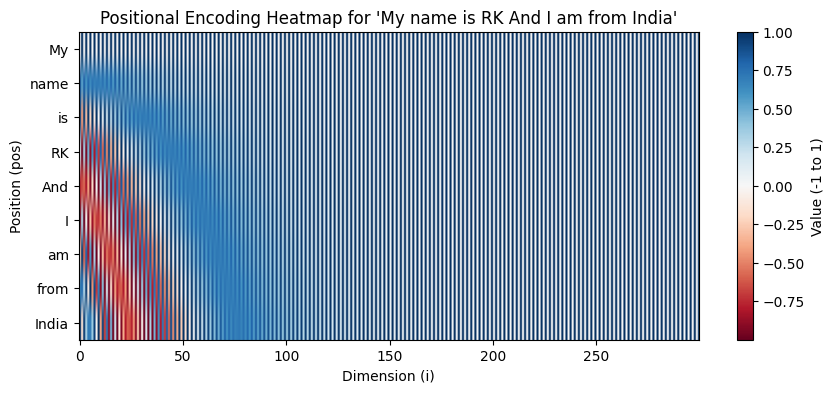

From the above plot we can see 
1. If you look at the plot horizontally (row by row), you’ll see that no two rows are identical.
2. Encoding is bounded. It will never create massive numbers that "break" the model's math, no matter how long the sentence is

### The Biggest advantage of this approach

The major advantage of sinusoidal positional encoding is its ability to represent relative positional relationships between tokens. The encoding is constructed in such a way that applying a linear transformation to the positional vector of a token can map it to the positional vector of another token at a fixed offset.

For instance, consider a token located at position 10 in a sequence. If a specific linear transformation $𝑇$ is applied to its positional encoding and the result corresponds to the positional encoding of position 15, then applying the same transformation $𝑇$ to the encoding of position 15 will yield the encoding of position 20. This demonstrates that positional shifts can be represented through consistent linear transformations.

Importantly, these transformations remain consistent across all positions in the sequence, enabling the model to generalize positional relationships effectively. This property allows the attention mechanism to efficiently learn patterns based on relative distances between tokens rather than relying solely on absolute positional values.

Lets try to find out that transformation matrix $T$

$$PE_{(pos, 2i)} = \sin(\omega_i \cdot pos)$$

$$PE_{(pos, 2i+1)} = \cos(\omega_i \cdot pos)$$

where 

$$\omega_i = \frac{1}{10000^{2i/d_{model}}}$$

What We Want to Prove:
We want to show that the encoding at a new position ($pos + k$) can be found by applying a linear transformation ($T$) to the current position ($pos$):

$$PE_{(pos+k)} = T_k \cdot PE_{(pos)}$$

To prove this, we use these two standard math rules:
$$\sin(a+b) = \sin(a)\cos(b) + \cos(a)\sin(b)$$

$$\cos(a+b) = \cos(a)\cos(b) - \sin(a)\sin(b)$$

For the Sine dimension:
$$\sin(\omega(pos+k)) = \sin(\omega \cdot pos)\cos(\omega \cdot k) + \cos(\omega \cdot pos)\sin(\omega \cdot k)$$

For the Cosine dimension:$$\cos(\omega(pos+k)) = \cos(\omega \cdot pos)\cos(\omega \cdot k) - \sin(\omega \cdot pos)\sin(\omega \cdot k)$$

If we define our position vector as:

$$v_{pos} = \begin{bmatrix} \sin(\omega \cdot pos) \\ \cos(\omega \cdot pos) \end{bmatrix}$$

Then the shifted position $v_{pos+k}$ is calculated as:

$$v_{pos+k} = \begin{bmatrix} \cos(\omega k) & \sin(\omega k) \\ -\sin(\omega k) & \cos(\omega k) \end{bmatrix} \cdot \begin{bmatrix} \sin(\omega \cdot pos) \\ \cos(\omega \cdot pos) \end{bmatrix}$$

So here is our transformation 
$$T_k = \begin{bmatrix} \cos(\omega k) & \sin(\omega k) \\ -\sin(\omega k) & \cos(\omega k) \end{bmatrix}$$

After calculating these Positional Encoding (PE) vectors, we simply add them to our original Word Embeddings.

$$\text{Final Vector} = \text{Word Embedding} + \text{Positional Encoding}$$

Why "Add" and not "Combine" or "Append"? 

Keeps the Size Same: By adding them, the vector stays 512 dimensions. If we attached them side-by-side, the vector would get longer and longer, making the model slower and more expensive to run.

## References:

* *Attention is All you need: https://arxiv.org/abs/1706.03762*
* *Youtube: https://youtu.be/GeoQBNNqIbM?si=ObUB0eC04gwf5SbR*